#### Pytorch codes for the paper 'Unsupervised Sentinel-2 Image Fusion Using A Deep Unrolling Method', submitted to GRSL
Han Van Nguyen, Magnus O. Ulfarsson, Johannes R. Sveinsson and Mauro Dalla Mura <br>
hvn2@hi.is<br>
**Main ideas:** Unroll the ADMM algorithm into a deep nerual network and train it using a loss function based on the Stein's unbiased risk estimated (SURE), which dose not require ground truthm, so that the method is unsupervised.  

In [1]:
import numpy as np
import torch
import skimage.io as io
import matplotlib.pyplot as plt
import scipy.io as sio
from models.s2_models import *
from models.skip import *
from utils.s2_utils import *
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Create simulated data by:
1. Load ground truth
2. Apply filtering and downsampling
3. Add noise

In [2]:
# Load ground truth
Xm = sio.loadmat('data/S2/apex_gt')['Xm_im']
[nl, nc, L] = Xm.shape
Xm_im=torch.from_numpy(Xm/np.max(Xm)).float()
X = Xm_im.permute(2, 0, 1).to(device)
# Simulate LR image
d = np.array([6, 1, 1, 1, 2, 2, 2, 1, 2, 6, 2, 2])
dx = 15
dy = 15
FBM = create_conv_kernel(nl, nc, dx, dy).to(device)
Y=AxS2(X,FBM) # LR image
Yim=[]  # noisy LR image
SNRdb=30
SNR = 10**(SNRdb/10.)
sigma = []
for i in range(len(Y)):
    sig = torch.sqrt(torch.mean(Y[i]**2)/SNR)
    Yim.append(Y[i]+sig*torch.randn(Y[i].shape).to(device))
    sigma.append(sig.to(device))
xref=Xm_im[:,:,d!=1].numpy()

In [3]:
# for i in range(len(Yim)):
#     plt.imshow(Yim[i].cpu().numpy(),cmap='gray')
#     plt.colorbar()
#     plt.show()

In [4]:
# Define network and optimizer (network is defined in models.s2_models)
net = S2UnrollNet(rho0=10.0).to(device) #unrolling net
optimizer = torch.optim.Adam(net.parameters(),lr = 0.01,amsgrad=True,eps=1e-3)

In [5]:
# Initialization and parameters
loss_type='sure'
cond=1e-3*torch.ones((12,1,1)).to(device)
x0=BPS2(Yim,FBM,cond) # input
u0 = torch.zeros_like(x0)
max_iter = 3000

Iteration 00000  Loss = 59583.14844  Residual=-5.01968


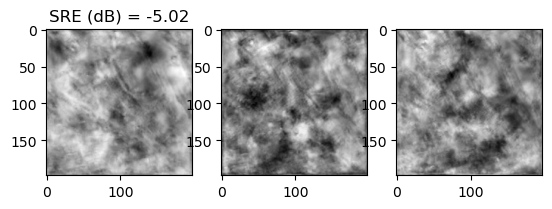

Iteration 00500  Loss = 129.68590  Residual=22.85472


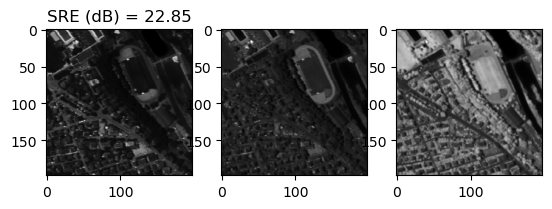

Iteration 01000  Loss = 111.81632  Residual=24.13518


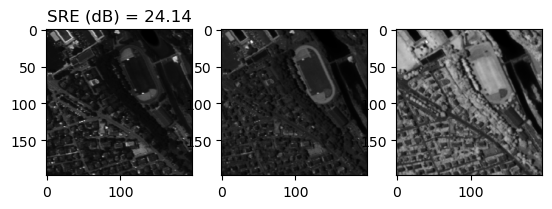

Iteration 01500  Loss = 109.87938  Residual=24.54095


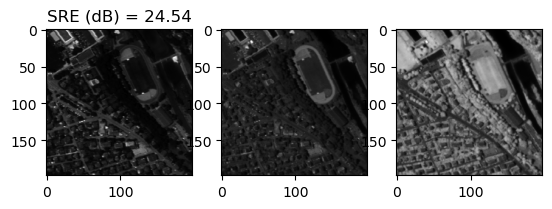

Iteration 02000  Loss = 105.16949  Residual=24.99810


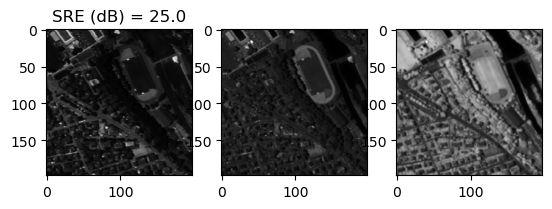

Iteration 02500  Loss = 104.06511  Residual=25.12838


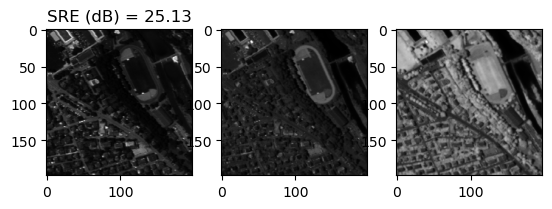

In [6]:
# Loss function is defined in models.s2_models
# Help functions are denfined in utils.s2_utils
sre_total=[]
show_every=500
for it in range(max_iter):    
    loss, xhat = SURE_S2_loss(x0,u0,net,Yim,sigma,FBM,cond,loss_type=loss_type)
    x = chw2hwc(xhat).detach().cpu().numpy()
    sre_total.append(sreCal(xref,x[:,:,d!=1]))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if it%show_every==0:
        band=0
        print('Iteration %05d  Loss = %.5f  Residual=%.5f' % (it,loss.detach().cpu().numpy(),sreCal(xref,x[:,:,d!=1])))
        plt.subplot(131)
        plt.imshow(xhat[band].detach().cpu().numpy(),cmap='gray')
        plt.title('SRE (dB) = '+str(np.round(sreCal(xref,x[:,:,d!=1]),2)))
        plt.subplot(132)
        plt.imshow(xhat[4].detach().cpu().numpy(),cmap='gray')
        plt.subplot(133)
        plt.imshow(xhat[9].detach().cpu().numpy(),cmap='gray')
        plt.show()

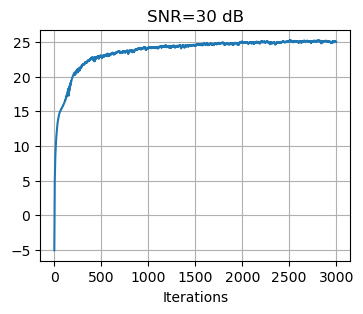

25.236654430627823


In [7]:
fig=plt.figure(figsize=(4,3))
plt.plot(np.asarray(sre_total))
plt.xlabel('Iterations')
plt.grid()
plt.title('SNR=30 dB')
plt.show()
print(np.max(sre_total))